In [2]:
import findspark
findspark.init()

from pyspark import SparkContext
# truy xuất đến hdfs của cô
SparkContext.setSystemProperty('spark.hadoop.dfs.client.use.datanode.hostname', 'true')

# khởi tạo sparkcontext, mở chìa khoá
# chạy ở máy cá nhân là local, sau này nếu có cái key/IP của máy master thì thay thế vào
sc = SparkContext(master="local", appName="New Spark Context")

from pyspark.sql import SparkSession
spark = SparkSession(sc)
spark

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/04 20:13:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import col, explode

In [4]:
rating = spark.read.csv('rating.csv', inferSchema=True, header=True)

In [5]:
rating.show(5)

+----------+-------+------+
|product_id|user_id|rating|
+----------+-------+------+
|       190|      1|     5|
|       190|      2|     5|
|       190|      3|     5|
|       190|      4|     5|
|       190|      5|     5|
+----------+-------+------+
only showing top 5 rows



In [6]:
users = rating.select('user_id').distinct().count()
products = rating.select('product_id').distinct().count()
numerator = rating.count()

In [7]:
display(numerator, users, products)

999815

650636

31267

In [8]:
denominator = users * products 
denominator

20343435812

In [9]:
sparsity = 1 - (numerator*1.0/ denominator)
print('sparsity: ', sparsity)

sparsity:  0.9999508531887514


In [10]:
# split data set to train & test 
(training, test) = rating.randomSplit([0.8,0.2])

# Build model

In [11]:
# Define parameter grid
regParams = [0.01, 0.05, 0.1]
maxIters = [10, 15, 20]

best_rmse = float("inf")
best_model = None
best_params = {}
results = []

evaluator = RegressionEvaluator(
    metricName = 'rmse',
    labelCol='rating',
    predictionCol='prediction'
)

for reg in regParams:
    for iter_ in maxIters:
        als = ALS(
            maxIter=iter_,
            regParam=reg,
            userCol='user_id',
            itemCol='product_id',
            ratingCol='rating',
            coldStartStrategy='drop',
            nonnegative=True
        )
        model = als.fit(training)
        predictions = model.transform(test)
        rmse = evaluator.evaluate(predictions)
        print(f"reg={reg}, iter={iter_} -> RMSE: {rmse:.4f}")
        
            # Append to result table
        results.append({
            'regParam': reg,
            'maxIter': iter_,
            'rmse': rmse
        })
                    
        if rmse < best_rmse:
            best_rmse = rmse
            best_model = model
            best_params = {'regParam': reg, 'maxIter': iter_}

print("✅ Best Model Params:", best_params)
print("⭐ Best RMSE:", best_rmse)


25/04/04 20:13:41 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/04/04 20:13:41 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
25/04/04 20:13:49 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


reg=0.01, iter=10 -> RMSE: 1.7226


reg=0.01, iter=15 -> RMSE: 1.6086


reg=0.01, iter=20 -> RMSE: 1.5237


reg=0.05, iter=10 -> RMSE: 1.3654


reg=0.05, iter=15 -> RMSE: 1.2705


reg=0.05, iter=20 -> RMSE: 1.2252


reg=0.1, iter=10 -> RMSE: 1.2216


reg=0.1, iter=15 -> RMSE: 1.1573


reg=0.1, iter=20 -> RMSE: 1.1397
✅ Best Model Params: {'regParam': 0.1, 'maxIter': 20}
⭐ Best RMSE: 1.1397355291734246


In [12]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS 

als = ALS(
    maxIter = 20,
    regParam = 0.1,
    userCol = 'user_id',
    itemCol = 'product_id', 
    ratingCol='rating', 
    coldStartStrategy = 'drop',
    nonnegative = True
)

model = als.fit(training)

In [13]:
from pyspark.sql import Row
from pyspark.sql.functions import format_number

results_rows = [Row(**row) for row in results]
results_df = spark.createDataFrame(results_rows)


In [14]:
results_df.select(
    "regParam", "maxIter",
    format_number("rmse", 2).alias("rmse_rounded")
).show()

+--------+-------+------------+
|regParam|maxIter|rmse_rounded|
+--------+-------+------------+
|    0.01|     10|        1.72|
|    0.01|     15|        1.61|
|    0.01|     20|        1.52|
|    0.05|     10|        1.37|
|    0.05|     15|        1.27|
|    0.05|     20|        1.23|
|     0.1|     10|        1.22|
|     0.1|     15|        1.16|
|     0.1|     20|        1.14|
+--------+-------+------------+



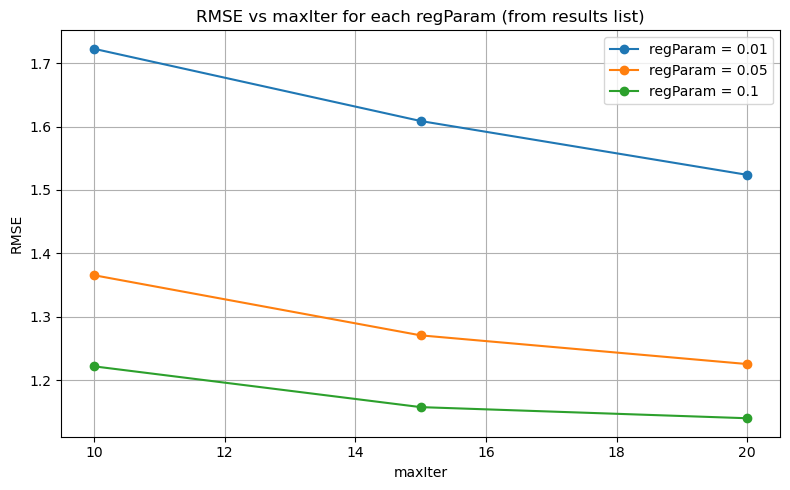

In [15]:
import matplotlib.pyplot as plt
# Organize data for plotting
plt.figure(figsize=(8, 5))
for reg in sorted(set(d['regParam'] for d in results)):
    x = [d['maxIter'] for d in results if d['regParam'] == reg]
    y = [d['rmse'] for d in results if d['regParam'] == reg]
    plt.plot(x, y, marker='o', label=f"regParam = {reg}")

# Plot config
plt.xlabel("maxIter")
plt.ylabel("RMSE")
plt.title("RMSE vs maxIter for each regParam (from results list)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
evaluator = RegressionEvaluator(
    metricName = 'rmse',
    labelCol='rating',
    predictionCol='prediction'
)

In [17]:
predictions = model.transform(test)

In [18]:
predictions.show(5)

+----------+-------+------+----------+
|product_id|user_id|rating|prediction|
+----------+-------+------+----------+
|      1088|     30|     5| 4.7939024|
|     18944|     33|     5| 4.6028614|
|     21220|     33|     5| 3.0838447|
|     23271|     33|     5|  4.917372|
|    171006|     33|     5|  4.716707|
+----------+-------+------+----------+
only showing top 5 rows



In [19]:
from pyspark.sql.functions import max
predictions.select(max('prediction')).show()

+---------------+
|max(prediction)|
+---------------+
|       6.481843|
+---------------+



In [20]:
evaluator = RegressionEvaluator(
    metricName = 'rmse',
    labelCol='rating',
    predictionCol='prediction'
)
rmse = evaluator.evaluate(predictions)
print('Root mean square error', str(rmse))

Root mean square error 1.1397355291734246


In [21]:
# recommend 10 best items (products) for each user
user_recs = model.recommendForAllUsers(10)

In [22]:
user_recs.printSchema()

root
 |-- user_id: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- product_id: integer (nullable = true)
 |    |    |-- rating: float (nullable = true)



In [23]:
user_recs.show(10, truncate=False)

+-------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|user_id|recommendations                                                                                                                                                                                              |
+-------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|26     |[{172806, 3.133127}, {22443, 3.094326}, {21899, 3.0716488}, {164712, 3.0410953}, {16110, 2.9961257}, {233887, 2.9952083}, {22261, 2.9930468}, {241046, 2.9912846}, {111231, 2.989623}, {173969, 2.9830613}]  |
|27     |[{101093, 5.9157495}, {12461, 5.902672}, {172333, 5.8176746}, {233729, 5.715339}, {121355, 5.713888}, {174430, 5.6960406}, {141

In [24]:
product_df = spark.read \
    .option("header", True) \
    .option("multiline", True) \
    .option("quote", '"') \
    .option("escape", '"') \
    .option("inferSchema", True) \
    .csv("cung_cap_HV/Products_ThoiTrangNam_raw.csv")


In [25]:
product_df.show(5)

+----------+--------------------+--------------+------------+--------------------+--------------------+-------+------+--------------------+
|product_id|        product_name|      category|sub_category|                link|               image|  price|rating|         description|
+----------+--------------------+--------------+------------+--------------------+--------------------+-------+------+--------------------+
|       190|Áo ba lỗ thun gân...|Thời Trang Nam|    Áo Ba Lỗ|https://shopee.vn...|https://cf.shopee...|86250.0|   4.9|Danh Mục\nShopee\...|
|       191|Áo Ba Lỗ Nam Trắn...|Thời Trang Nam|    Áo Ba Lỗ|https://shopee.vn...|https://cf.shopee...|26800.0|   4.9|Danh Mục\nShopee\...|
|       192|Áo Ba Lỗ Nam Tyas...|Thời Trang Nam|    Áo Ba Lỗ|https://shopee.vn...|https://cf.shopee...|39500.0|   4.8|Danh Mục\nShopee\...|
|       193|ÁO BA LỖ HÀNG VIỆ...|Thời Trang Nam|    Áo Ba Lỗ|https://shopee.vn...|https://cf.shopee...|16500.0|   4.8|Danh Mục\nShopee\...|
|       194|Áo Thun 

In [26]:
from pyspark.sql.functions import explode, col

# Step 1: Explode recommendations (array of struct → rows)
exploded_recs = user_recs.select(
    col("user_id"),
    explode("recommendations").alias("rec")
).select(
    col("user_id"),
    col("rec.product_id").alias("product_id"),
    col("rec.rating").alias("predicted_rating")
)

# Step 2: Join with product_df to get product names
recs_with_names = exploded_recs.join(
    product_df.select("product_id", "product_name", "sub_category"), on="product_id", how="left"
)

# Step 3: Show results
recs_with_names.select("user_id", "product_id", "product_name", "sub_category", "predicted_rating").show(truncate=False)


+-------+----------+-----------------------------------------------------------------------------------------------------------------------+-----------------------+----------------+
|user_id|product_id|product_name                                                                                                           |sub_category           |predicted_rating|
+-------+----------+-----------------------------------------------------------------------------------------------------------------------+-----------------------+----------------+
|27     |233729    |Sét áo và chân váy nữ dự tiệc cúc họa mi trắng áo kiểu Croptop có mút ngực tay bo thun phối chân váy xếp tầng dễ thương|Đồ Bộ                  |5.715339        |
|26     |22443     |Áo cardigan loang màu / Cardigan tiedye BMO unisex                                                                     |Áo Vest và Blazer      |3.094326        |
|27     |141453    |QUẦN LỬNG BERMUDA LIDER JESSE DENIM SHORTS                            

In [ ]:
recs_with_names.filter("user_id = 45") \
    .orderBy("predicted_rating", ascending=False) \
    .select("user_id", "product_id", "product_name",'sub_category', "predicted_rating") \
    .show(10, truncate=False)



+-------+----------+-----------------------------------------------------------------------------------------------------------------------+--------------+----------------+
|user_id|product_id|product_name                                                                                                           |sub_category  |predicted_rating|
+-------+----------+-----------------------------------------------------------------------------------------------------------------------+--------------+----------------+
|45     |101093    |Cà vạt nam 8cm bản to giá siêu rẻ, cravat công sở, trung niên, cavat phong cách chững chạc                             |Cà vạt & Nơ cổ|5.9157495       |
|45     |12461     |Kính mát nam BMW-GV thời trang cao cấp ,full box, tròng Polazied, chống lóa , chống tia UV cực tốt                     |Kính Mắt Nam  |5.902672        |
|45     |172333    |Bodysiut cho bé trai bé gái dài tay tam giác và có tất đáng yêu Nga Fish BD-NE                                     

In [28]:
recs_with_names.filter("user_id = 30") \
    .orderBy("predicted_rating", ascending=False) \
    .select("user_id", "product_id", "product_name",'sub_category', "predicted_rating") \
    .show(10, truncate=False)


+-------+----------+---------------------------------------------------------------------------------+-------------------------+----------------+
|user_id|product_id|product_name                                                                     |sub_category             |predicted_rating|
+-------+----------+---------------------------------------------------------------------------------+-------------------------+----------------+
|30     |131154    |[mẫu mới] Quần Jogger nam nữ thun da cá Hàn quốc                                 |Quần Dài/Quần Âu         |6.1228504       |
|30     |16227     |Áo dài nam đón tết                                                               |Trang Phục Truyền Thống  |6.085448        |
|30     |141293    |Quần jean nam co giãn BIGSIZE từ 75-90KG                                         |Quần Jeans               |6.075349        |
|30     |23815     |Áo ĐI BIỂN HÓT HIT Ạ ( CÓ QUẦN ĐĂNG RIÊNG)                                       |Đồ Bộ                 

In [29]:
recs_with_names.filter("user_id = 200") \
    .orderBy("predicted_rating", ascending=False) \
    .select("user_id", "product_id", "product_name",'sub_category', "predicted_rating") \
    .show(10, truncate=False)


+-------+----------+-----------------------------------------------------------+-----------------------+----------------+
|user_id|product_id|product_name                                               |sub_category           |predicted_rating|
+-------+----------+-----------------------------------------------------------+-----------------------+----------------+
|200    |191197    |Combo 2 áo ba lỗ nam RSC01 Cotton mỏng vừa thoáng mát      |Áo Ba Lỗ               |6.0611777       |
|200    |19204     |[ ÁO TANKTOP ] Áo bo lỗ nam đẹp, Áo ba lỗ nam tập gym      |Áo Ba Lỗ               |5.8798018       |
|200    |232526    |Áo thun cặp form rộng (ảnh thật)                           |Đồ Bộ                  |5.848368        |
|200    |211616    |Áo phao nam siêu nhẹ 2 mặt !ảnh thật tự chụp từ 50 đến 80kg|Áo Khoác               |5.800338        |
|200    |111606    |Đôi khuyên tai kiểu dáng tùy chọn cho nữ                   |Khác                   |5.753497        |
|200    |111927    |Kẹp 